# Udacity Capstone Project: Arvato Financial Services Customer Segmentation and Machine Learning Analysis

**By: Andrew Wrist**

In this project, demographics data was analyzed for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. Unsupervised learning techniques were utilized to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, what was learned was applied on a third dataset with demographics information for targets of a marketing campaign for the company, and a model was developed to predict which individuals are most likely to convert into becoming customers for the company. The data was provided by Bertelsmann Arvato Analytics, and represents a real-life data science task. The versions of those two datasets used in this project include many more features and has not been pre-cleaned.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ast
import time

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve
import xgboost as xgb

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. The information from the first two files was used to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then used to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In [5]:
# Insert directory containing data files below
directory = '/Users/andrewwrist/Documents/Training/Udacity_Data_Science/Capstone_Project/data/'
os.chdir(directory) #load directory

In [6]:
# Load in the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')

/var/folders/dz/71j5m95x01d2wwbm3pz62vz80000gn/T/ipykernel_64359/3148705287.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
/var/folders/dz/71j5m95x01d2wwbm3pz62vz80000gn/T/ipykernel_64359/3148705287.py:3: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')


In [7]:
def low_nan_cols(df, thresh = 25):
    '''
    Return columns with less than 25% of values missing
    INPUT
    -df: DataFrame
    -thresh: threshold of what is considered the "low" threshold
    
    OUTPUT
    -df_missing: DataFrame with columns below indicated threshold of missing values
    '''
    df_pcnt_missing = df.isnull().mean()*100 #calculates percent nans in each column
    df_missing = df_pcnt_missing[df_pcnt_missing<thresh]
    df_missing = df_missing.sort_values(ascending = False)
    return df_missing

def high_nan_cols(df, thresh = 50):
    '''
    Return columns with less greater than 50% of values missing
    INPUT
    -df: DataFrame
    -thresh: threshold of what is considered the "high" threshold
    
    OUTPUT
    -df_missing: DataFrame with columns above indicated threshold of missing values
    '''
    df_pcnt_missing = df.isnull().mean()*100 #calculates percent nans in each column
    df_missing = df_pcnt_missing[df_pcnt_missing>thresh]
    df_missing = df_missing.sort_values(ascending = False)
    return df_missing

def describe_dataframe(df):
    '''
    Describe df shape and numer of columns with >50% missing values
    '''
    rows, cols, = df.shape
    qty_missing = high_nan_cols(df).nunique()
    print('The selected dataframe has %i rows and %i columns.' % (rows, cols))
    print('Columns with >50% values missing: ', qty_missing)
    
def plot_missing_values_features(df):
    '''
    Plot the top 20 features by % of missing values
    OUTPUT
    -plot of features with missing values and their % of missing values
    '''
    df_pcnt_missing = azdias.isnull().mean()*100
    pcnt_missing_list = df_pcnt_missing.sort_values(ascending=False)
    ax = pcnt_missing_list[:20].plot(kind='bar', figsize = (16,8));
    ax.set_xlabel("Feature Name")
    ax.set_ylabel("Percent Missing Values")
    ax.set_title("Top 20 Features by Missing Value Percent")

    font = {'family' : 'normal',
            'weight' : 'bold',
            'size'   : 16}

    plt.rc('font', **font);

In [8]:
describe_dataframe(azdias)
azdias.head()

The selected dataframe has 891221 rows and 366 columns.
Columns with >50% values missing:  6


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


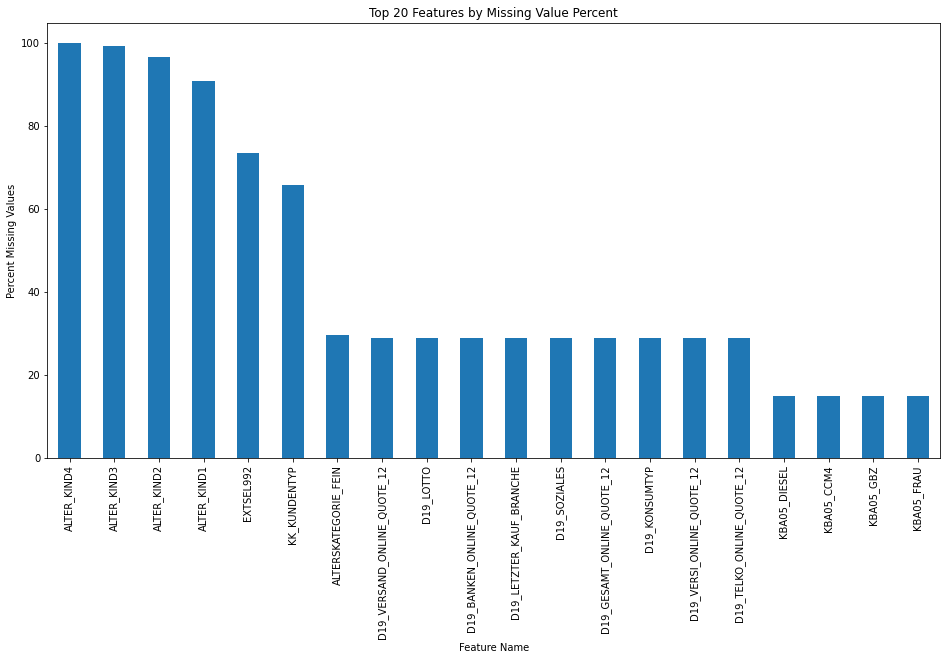

In [9]:
plot_missing_values_features(azdias)

In [10]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [11]:
describe_dataframe(customers)
customers.head()

The selected dataframe has 191652 rows and 369 columns.
Columns with >50% values missing:  5


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


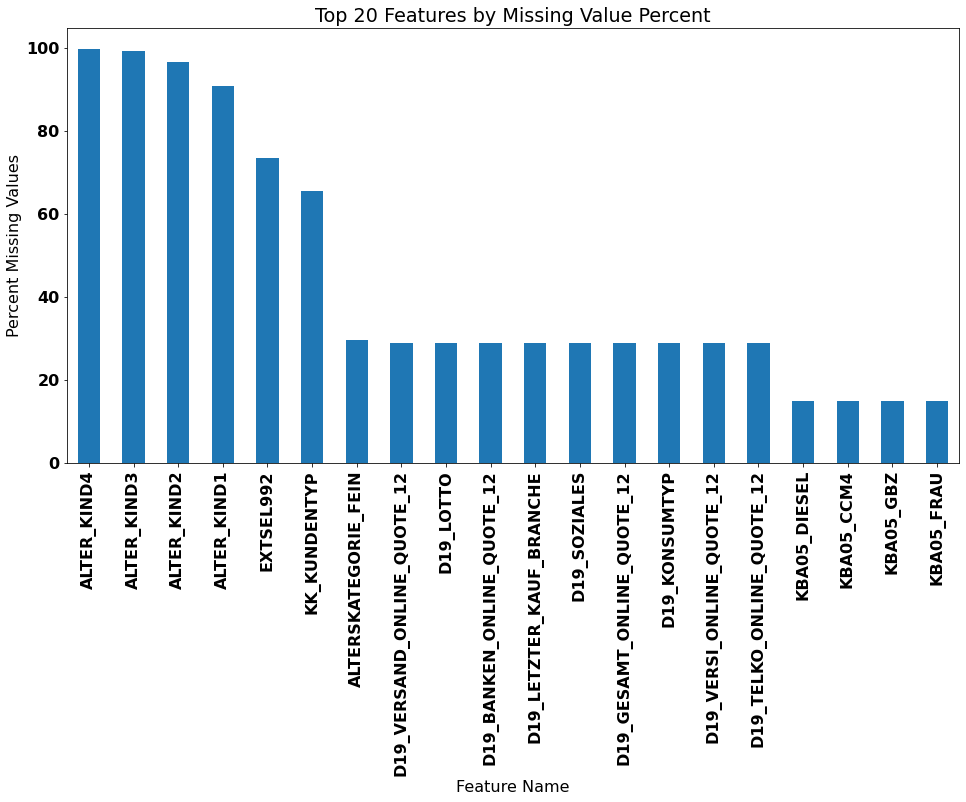

In [12]:
plot_missing_values_features(customers)

In [13]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


In [14]:
azdias_cols = set(azdias.columns)
customers_cols = set(customers.columns)
customers_exclusive_columns = customers_cols - azdias_cols
print(customers_exclusive_columns)

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}


There are 3 columns that appear in the Customers data set that do not appear in Azdias

In [15]:
attr_vals = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1, dtype = 'str')
attr_vals = attr_vals.drop('Unnamed: 0', axis = 1)

In [16]:
attr_vals.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly


In [17]:
#create set of attribute values features
attr_features = set(attr_vals[attr_vals['Attribute'].notnull()]['Attribute'])
azdias_features = set(azdias.columns)

#determine differences between features in dias set and azdias set
azdias_features_not_in_dias = azdias_features - attr_features
dias_features_not_in_azdias = attr_features - azdias_features

print('There are %i features present in azdias that are not in the dias set' %len(azdias_features_not_in_dias))
print('There are %i features present in dias that are not in the azdias set' %len(dias_features_not_in_azdias))

There are 94 features present in azdias that are not in the dias set
There are 42 features present in dias that are not in the azdias set


In [18]:
#display all unique meaning values from attribute values
unique_meanings = attr_vals.Meaning.unique()
unique_meanings

array(['unknown', 'no classification possible', 'passive elderly',
       'cultural elderly', 'experience-driven elderly', '< 30 years',
       '30 - 45 years', '46 - 60 years', '> 60 years',
       'uniformly distributed', 'unknown / no main age detectable',
       '01.01.1895 bis 31.12.1899', '01.01.1900 bis 31.12.1904',
       '01.01.1905 bis 31.12.1909', '01.01.1910 bis 31.12.1914',
       '01.01.1915 bis 31.12.1919', '01.01.1920 bis 31.12.1924',
       '01.01.1925 bis 31.12.1929', '01.01.1930 bis 31.12.1934',
       '01.01.1935 bis 31.12.1939', '01.01.1940 bis 31.12.1944',
       '01.01.1945 bis 31.12.1949', '01.01.1950 bis 31.12.1954',
       '01.01.1955 bis 31.12.1959', '01.01.1960 bis 31.12.1964',
       '01.01.1965 bis 31.12.1969', '01.01.1970 bis 31.12.1974',
       '01.01.1975 bis 31.12.1979', '01.01.1980 bis 31.12.1984',
       '01.01.1985 bis 31.12.1989', '01.01.1990 bis 31.12.1994',
       '01.01.1995 bis 31.12.1999', 'male', 'female',
       'numeric value (typically cod

From exploring the unique meanings from the attributes values "Meaning" column, we found "X", "XX", "unkown", and "unknown / no main age detectable" represented missing values. Later, these will be replaced by nans.

In [19]:
print(azdias['CAMEO_DEUG_2015'].unique())
print(azdias['CAMEO_INTL_2015'].unique())

[nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1' 'X']
[nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44'
 '35' '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45'
 'XX']


**Based on the data analyses above, the following considerations are made during the data cleaning process:**

- There are 6 columns in the Azdias data with >50% values missing. We need to drop columns with >50% values missing in both datasets.

- Unknown "meaning" values need to be replaced by NaNs in the AZDIAS and Customers data sets. These are represented by "unknown" and "unknown / no main age detectable". Therefore, a function will be developed to replace those unknown values with NaNs.

- The features "CAMEO_DEUG_2015" and "CAMEO_INTL_2015" have multiple data types, and "X" and "XX" values. The X needs to be converted to nan, and the datatypes need to be changed to integers.

- "EINGEFUEGT_AM" should be converted to a year.

- "OST_WEST_KZ" could benefit from being converted to binary. 

All of these modifications will be included in the cleaning functions.

In [20]:
def fix_cameo(df, feature):
    '''
    The features "CAMEO_DEUG_2015" and "CAMEO_INTL_2015" have multiple 
    data types, an "X" and "XX" values. The X needs to be converted to 
    nan, and the datatypes need to be changed to integers.
    
    INPUT: 
    - df: dataframe
    - feature to replace
    OUPUT: 
    - df with cleaned cameo features
    '''
    df[feature].replace(['X','XX'],np.nan, inplace=True)
    df[feature] = df[feature].astype(float)
    return df

def clean_dataframe(df):
    '''
    Cleans dataframe by replacing missing values with nans, converting dates to years, replacing
    binary categorical variable with 1s and 0s, and dropping columns with >50% missing.
    INPUT:
    df: dataframe to be cleaned
    OUTPUT:
    df: cleaned dataframe
    '''
    #Create a dictionary for missing values from the attributes values data set
    missing_vals_dict = {}
    unknown_vals = attr_vals[attr_vals['Meaning'].isin(['unknown','unknown / no main age detectable'])]
    for row, attr in unknown_vals.iterrows():
        attribute = attr['Attribute']
        val = attr['Value'].split(", ")
        missing_vals_dict[attribute] = val
    
    #replace missing values as denoted from the attributes values data with NaNs
    for attribute in missing_vals_dict:
        if attribute in df.columns:
            missing_val = missing_vals_dict[attribute]
            for val in missing_val:
                val = float(val)
                df[attribute].replace(val, np.NaN, inplace=True)
    
    #replace "EINGEFUEGT_AM" values with years
    df['EINGEFUEGT_AM'] = pd.to_datetime(df['EINGEFUEGT_AM']).dt.year
    
    #replace Ws with 1 and Os with 0 in the 'OST_WEST_KZ' column
    ost_west_dict = {'W': 1, 'O':0}
    df['OST_WEST_KZ'].replace(ost_west_dict, inplace=True)
    
    #drop columns with more than 50% of values missing
    df_high_nans_cols = high_nan_cols(df)
    df = df.drop(df_high_nans_cols.index.values,axis=1)
    
    return df

def describe_nan_rows(df):
    '''
    Provide a statistical description and histogram of rows with nan values
    INPUT:
    - df: dataframe to describe
    OUTPUT:
    - plot with percent missing values in rows
    '''
    nan_row_pcnts = df.isnull().sum(axis=1)/df.shape[1]*100
    print(nan_row_pcnts.describe())
    plt.hist(nan_row_pcnts);
    plt.xlabel('Pcnt missing values in row')
    plt.ylabel('Qty of rows')

def clean_nan_rows(df, thresh=25):
    '''
    Drop rows with number of missing values above threshold and return cleaned df
    INPUT:
    - df
    - threshold for % of missing values in rows
    OUTPUT:
    - cleaned dataframe
    '''
    #drop rows with number of missing values above threshold
    nan_row_pcnts = df.isnull().sum(axis=1)/df.shape[1]*100
    nan_rows_threshold = sum(nan_row_pcnts>thresh)/df.shape[0]*100
    df_clean = df[nan_row_pcnts < nan_rows_threshold]
    
    return df_clean

def fill_numeric_nans(df):
    '''
    Fill missing values for binary features using mode
    and mean for non-binary features and return cleaned binary and
    non-binary dfs
    INPUT:
    - df
    OUTPUT:
    - binary_df: cleaned df with binary features
    - nonbinary_df: cleaned df with nonbinary features
    '''
    #Set df with just numeric variables
    df_num = df.select_dtypes('number')
    
    #Create binary features list
    binary_features = []
    for col in df_num.columns:
        if df_num[col].nunique()==2:
            binary_features.append(col)
    
    #Create df with binary features and fill NaNs with mode for each column
    binary_df = df_num[binary_features]
    fill_mode = lambda col: col.fillna(col.mode()[0])
    # Fill the mode
    binary_df = binary_df.apply(fill_mode, axis=0)
    
    #Non-binary features
    nonbinary_df = df_num.drop(binary_features, axis=1)
    
    #Fill mean for all non-binary features
    fill_mean = lambda col: col.fillna(col.mean())
    #Fill the mean
    nonbinary_df = nonbinary_df.apply(fill_mean, axis=0)
    
    return binary_df, nonbinary_df


Now we will implement all of the cleaning functions from above.

In [21]:
#Replace X and XX with nan in CAMEO features and convert all to floats
azdias_clean = fix_cameo(azdias,'CAMEO_INTL_2015')
azdias_clean = fix_cameo(azdias_clean,'CAMEO_DEUG_2015')

print(azdias_clean['CAMEO_DEUG_2015'].unique())
print(azdias_clean['CAMEO_INTL_2015'].unique())

[nan  8.  4.  2.  6.  1.  9.  5.  7.  3.]
[nan 51. 24. 12. 43. 54. 22. 14. 13. 15. 33. 41. 34. 55. 25. 23. 31. 52.
 35. 45. 44. 32.]


In [22]:
azdias_clean = clean_dataframe(azdias_clean)

In [23]:
describe_dataframe(azdias_clean)

The selected dataframe has 891221 rows and 357 columns.
Columns with >50% values missing:  0


In [24]:
azdias_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 357 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(268), int64(87), object(2)
memory usage: 2.4+ GB


In [25]:
azdias_clean.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,9.0,NaN,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


count    891221.000000
mean          9.537323
std          21.211038
min           0.000000
25%           0.000000
50%           0.280112
75%           3.081232
max          71.428571
dtype: float64


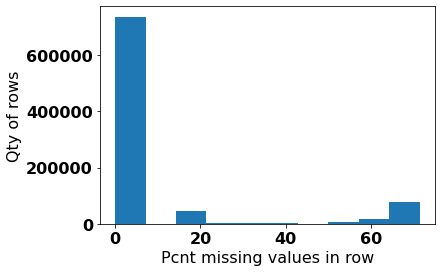

In [26]:
describe_nan_rows(azdias_clean)

The mean percent of missing values per row is 7.7, with a std of 17.3. Therefore, a threshold of 25% was set, and any rows with >25% missing are eliminated. This results in a reduction of 11.87% of rows.

count    737288.000000
mean          0.893275
std           1.351510
min           0.000000
25%           0.000000
50%           0.000000
75%           1.400560
max          11.204482
dtype: float64


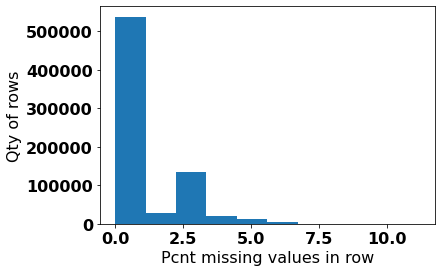

In [27]:
azdias_clean_rows = clean_nan_rows(azdias_clean)
describe_nan_rows(azdias_clean_rows)

In [28]:
azdias_clean_rows.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 737288 entries, 1 to 891220
Columns: 357 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(268), int64(87), object(2)
memory usage: 2.0+ GB


In [29]:
azdias_clean_rows.select_dtypes('number').shape[1]

355

355 numeric features now exist after the cleaning steps performed to this point. To handle nans in these features, the mean can be used for features with more than 2 features. However, for binary features, it makes more sense to use the mode value. Therefore, we will split the numeric features out based on binary and non-binary features and fill nans with mode and mean values respectively. 

**Handling Binary and Non-Binary Features**

In [30]:
azdias_binary, azdias_nonbinary = fill_numeric_nans(azdias_clean_rows)

In [31]:
print((azdias_binary.isnull().mean()>0).unique()[0])

False


In [32]:
print((azdias_nonbinary.isnull().mean()>0).unique()[0])

False


There are no nans remaining in numeric features!

**Final touch-up**

In [33]:
#Determine what non-numeric features remain
azdias_clean_rows.select_dtypes('object').columns

Index(['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE'], dtype='object')

In [34]:
print(azdias_clean_rows['CAMEO_DEU_2015'].nunique())
print(azdias_clean_rows['D19_LETZTER_KAUF_BRANCHE'].nunique())

45
35


Since the two remaining categorical columns both have more than 30 values, we will not include them in the final, merged dataset for anlaysis.

In [35]:
#Merge numeric dataframes
azdias_merged = pd.merge(azdias_nonbinary, azdias_binary ,left_index=True,right_index=True)

In [36]:
azdias_merged.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,DSL_FLAG,GREEN_AVANTGARDE,HH_DELTA_FLAG,KBA05_SEG6,KONSUMZELLE,OST_WEST_KZ,SOHO_KZ,UNGLEICHENN_FLAG,VERS_TYP,ANREDE_KZ
1,910220,9.0,15.271029,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,1.0,0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2
2,910225,9.0,17.000000,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,1.0,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2
3,910226,1.0,13.000000,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,1.0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2
4,910241,1.0,20.000000,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,1.0,0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1
5,910244,1.0,10.000000,10.0,5.0,0.0,0.0,1.0,2.0,0.0,...,1.0,0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2


In [37]:
#Drop ID from azdias merged since it will not be used during machine learning processes
azdias_merged = azdias_merged.drop('LNR', axis=1)

In [38]:
azdias_merged.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,DSL_FLAG,GREEN_AVANTGARDE,HH_DELTA_FLAG,KBA05_SEG6,KONSUMZELLE,OST_WEST_KZ,SOHO_KZ,UNGLEICHENN_FLAG,VERS_TYP,ANREDE_KZ
1,9.0,15.271029,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,1.0,0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2
2,9.0,17.000000,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,1.0,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2
3,1.0,13.000000,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,1.0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2
4,1.0,20.000000,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,1.0,0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1
5,1.0,10.000000,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,1.0,0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2


**Clean Customers Dataset**

The same cleaning methods will be applied to the Customers dataset in addition to removing the three rows not included in AZDIAS.

In [39]:
describe_dataframe(customers)
customers.head()

The selected dataframe has 191652 rows and 369 columns.
Columns with >50% values missing:  5


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [40]:
azdias_cols = set(azdias.columns)
customers_cols = set(customers.columns)
customers_exclusive_columns = customers_cols - azdias_cols
print(customers_exclusive_columns)

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}


Remember from earlier, the Customers dataset has three additional columns that are not present in the AZDIAS dataset. Those features will need to be dropped before cleaning the Customers dataset.

In [41]:
customers_reduced = customers.drop(customers_exclusive_columns, axis=1)

In [42]:
#Replace X and XX with nan in CAMEO features and convert all to floats
customers_clean = fix_cameo(customers_reduced,'CAMEO_INTL_2015')
customers_clean = fix_cameo(customers_clean,'CAMEO_DEUG_2015')

#Perform cleaning function on customers dataframe
customers_clean = clean_dataframe(customers_clean)

#Perform row reduction based on rows with greater than the threshold of nans in the data
customers_clean_rows = clean_nan_rows(customers_clean)

#Fill nans for binary and non-binary features in the customers dataset
#with mode and median, respectively
customers_binary, customers_nonbinary = fill_numeric_nans(customers_clean_rows)

#Merge binary and nonbinary dataframes for final customers dataframe
customers_merged = pd.merge(customers_nonbinary, customers_binary ,left_index=True,right_index=True)

#Drop ID from customers merged since it will not be used during machine learning
customers_merged = customers_merged.drop('LNR', axis=1)

In [43]:
customers_merged.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,DSL_FLAG,GREEN_AVANTGARDE,HH_DELTA_FLAG,KBA05_SEG6,KONSUMZELLE,OST_WEST_KZ,SOHO_KZ,UNGLEICHENN_FLAG,VERS_TYP,ANREDE_KZ
0,2.000000,1.0,10.0,10.0,1.0,0.000000,0.0,2.0,1.0,0.0,...,1.0,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1
2,1.574056,1.0,6.0,0.0,1.0,0.000000,0.0,1.0,1.0,0.0,...,1.0,1,0.0,0.0,1.0,1.0,0.0,0.0,2.0,2
3,1.000000,1.0,8.0,8.0,0.0,0.064271,0.0,0.0,1.0,0.0,...,1.0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
4,1.574056,1.0,20.0,14.0,7.0,0.000000,0.0,4.0,7.0,0.0,...,1.0,0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,1
5,1.000000,1.0,11.0,10.0,1.0,0.000000,0.0,2.0,1.0,0.0,...,1.0,1,0.0,1.0,0.0,1.0,0.0,0.0,2.0,1


Now that we have cleaned customers and AZDIAS dataframes, lets verify we have identical features in each dataframe

In [44]:
azdias_cols = set(azdias_merged.columns)
customers_cols = set(customers_merged.columns)
azdias_exclusive_columns = azdias_cols - customers_cols
customers_exclusive_columns = customers_cols - azdias_cols
print('Customers exclusive columns: ',customers_exclusive_columns)
print('AZDIAS exclusive columns: ',azdias_exclusive_columns)

Customers exclusive columns:  {'AGER_TYP', 'EXTSEL992'}
AZDIAS exclusive columns:  set()


We still have two additional columns in the Customers dataset that were cleaned out of the AZDIAS dataset. Since these columns did not pass our usefuleness test in AZDIAS, we will also drop them from Customers.

In [45]:
#drop columns that only appear in Customers after cleaning
customers_merged = customers_merged.drop(customers_exclusive_columns, axis=1)

In [46]:
describe_dataframe(customers_merged)
customers_merged.head()

The selected dataframe has 140365 rows and 354 columns.
Columns with >50% values missing:  0


,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,DSL_FLAG,GREEN_AVANTGARDE,HH_DELTA_FLAG,KBA05_SEG6,KONSUMZELLE,OST_WEST_KZ,SOHO_KZ,UNGLEICHENN_FLAG,VERS_TYP,ANREDE_KZ
0,1.0,10.0,10.0,1.0,0.000000,0.0,2.0,1.0,0.0,1.0,...,1.0,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1
2,1.0,6.0,0.0,1.0,0.000000,0.0,1.0,1.0,0.0,3.0,...,1.0,1,0.0,0.0,1.0,1.0,0.0,0.0,2.0,2
3,1.0,8.0,8.0,0.0,0.064271,0.0,0.0,1.0,0.0,1.0,...,1.0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
4,1.0,20.0,14.0,7.0,0.000000,0.0,4.0,7.0,0.0,3.0,...,1.0,0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,1
5,1.0,11.0,10.0,1.0,0.000000,0.0,2.0,1.0,0.0,3.0,...,1.0,1,0.0,1.0,0.0,1.0,0.0,0.0,2.0,1


## Part 1: Customer Segmentation Report

Here, unsupervised learning techniques were used to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, we are able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

**Principal Component Analysis (PCA)**

We will follow the following steps to perform a Principal Component Analysis:
- Standardize the data onto a unit scale for optimal machine learning performance
- Reduce features down to a limited number of principal components
- Identify what principal components explain the variance the most
- Identify the features with the highest weights of those components

In [48]:
#Initialize standard scaler
scaler = StandardScaler()

#Standardize dataframe 
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_merged))

#Reduce to Principal Components
pca = PCA()
principal_components = pca.fit_transform(azdias_scaled)

In [49]:
def scale_and_pca(df):
    '''
    Scale data and output resulting df and principal components
    INPUT
    df: dataframe to be analyzed
    OUTPUT
    df_scaled: scaled dataframe
    principal_components: principal components from scaled df
    '''
    #Standardize dataframe 
    df_scaled = pd.DataFrame(scaler.fit_transform(df))

    #Reduce to Principal Components
    pca = PCA()
    principal_components = pca.fit_transform(df_scaled)
    return df_scaled, principal_components

def plot_scree():
    '''
    Plot Scree plot
    '''
    #Plot PCA Scree Plot
    PC_values = np.arange(pca.n_components_)+1
    plt.plot(PC_values, pca.explained_variance_ratio_)
    plt.title('PCA Scree Plot')
    plt.xlabel('Principal Components')
    plt.ylabel('Variance Explained')
    plt.show()
    
def plot_cum_scree():
    '''plot cumulative scree plot'''
    #Plot PCA Cumulative Scree Plot with 0.9 threshold refernce line
    PC_values = np.arange(pca.n_components_)+1
    plt.plot(PC_values, np.cumsum(pca.explained_variance_ratio_))
    plt.axhline(y=0.9, color='r', linestyle='--')
    plt.title('PCA Cumulative Scree Plot')
    plt.xlabel('Qty Principal Components')
    plt.ylabel('Variance Explained')
    plt.show()
    
def component_weights(df, component_num):
    '''
    Returns a dataframe with component weights sorted by the most to least highest weights
    INPUT
    df: dataframe to be analyzed
    component_num: Principal Component number
    OUTPUT
    comp_weight = dataframe with component weights sorted by the most to least highest weights
    '''
    component_weights = pca.components_[component_num -1]
    comp_weight = pd.DataFrame(component_weights, columns = ['weight'], index = df.columns)
    comp_weight = comp_weight.sort_values(by='weight', ascending=False)
    
    return comp_weight

In [50]:
#assign azdias_scaled and principal components
azdias_scaled, azdias_principal_comps = scale_and_pca(azdias_merged)

In [51]:
azdias_scaled

,0,1,2,3,4,5,6,7,8,9,...,344,345,346,347,348,349,350,351,352,353
0,1.262251,0.000000,1.641715e+00,0.186813,-0.125875,-0.299061,0.224688,0.335407,-0.06066,-0.179348,...,0.104511,-0.536639,-0.316027,2.721533,1.794576,0.515933,10.842237,3.198128,0.907560,0.958448
1,1.262251,0.537718,7.482748e-01,0.120634,-0.125875,-0.299061,-0.634469,-0.031840,-0.06066,-0.179348,...,0.104511,1.863451,-0.316027,-0.367440,-0.557235,0.515933,-0.092232,-0.312683,-1.101855,0.958448
2,-0.934331,-0.706301,-1.451649e-01,-0.474979,-0.125875,-0.299061,-1.493626,-0.399086,-0.06066,-1.185226,...,0.104511,-0.536639,-0.316027,-0.367440,-0.557235,0.515933,-0.092232,-0.312683,-1.101855,0.958448
3,-0.934331,1.470733,7.819503e-02,-0.342620,-0.125875,-0.299061,1.943002,-0.325637,-0.06066,0.826531,...,0.104511,-0.536639,-0.316027,-0.367440,-0.557235,0.515933,-0.092232,-0.312683,0.907560,-1.043354
4,-0.934331,-1.639315,-8.152447e-01,-0.210262,-0.125875,-0.299061,-0.634469,-0.399086,-0.06066,-1.185226,...,0.104511,-0.536639,-0.316027,-0.367440,-0.557235,0.515933,-0.092232,-0.312683,0.907560,0.958448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737283,0.163960,0.537718,7.482748e-01,0.451529,-0.125875,-0.299061,-0.634469,0.261957,-0.06066,0.000000,...,0.104511,-0.536639,-0.316027,-0.367440,-0.557235,0.515933,-0.092232,-0.312683,-1.101855,0.958448
737284,1.262251,0.226714,5.249149e-01,0.186813,-0.125875,-0.299061,-0.634469,0.261957,-0.06066,0.826531,...,0.104511,-0.536639,-0.316027,-0.367440,1.794576,0.515933,-0.092232,-0.312683,0.907560,-1.043354
737285,-0.934331,0.537718,7.482748e-01,-0.342620,-0.125875,-0.299061,-1.493626,-0.325637,-0.06066,-1.185226,...,0.104511,-0.536639,-0.316027,-0.367440,-0.557235,0.515933,-0.092232,-0.312683,-1.101855,0.958448
737286,1.262251,0.000000,1.418355e+00,-0.077904,-0.125875,1.747570,-0.634469,-0.178738,-0.06066,0.826531,...,0.104511,-0.536639,-0.316027,-0.367440,-0.557235,0.515933,-0.092232,-0.312683,0.907560,-1.043354


In [52]:
azdias_principal_comps

array([[-4.55844189e+00,  8.74257848e-01,  6.48452733e+00, ...,
        -1.28704623e-02, -1.26217349e-01,  3.66479635e-15],
       [-1.34136453e-01, -2.37287795e+00,  2.11655383e+00, ...,
        -2.04843087e-02,  3.49902549e-02, -9.76261827e-16],
       [ 4.16095434e+00, -6.19490524e+00, -1.43251752e+00, ...,
        -4.35329291e-02, -3.53601872e-02,  1.88322376e-15],
       ...,
       [ 3.44386749e+00,  2.71087431e+00,  1.90913561e+00, ...,
         3.30520878e-02, -1.33859830e-01, -2.47040410e-15],
       [-7.75215636e+00,  5.47144314e+00, -2.58331072e+00, ...,
        -1.16047123e-02,  6.13820618e-02, -6.98890349e-16],
       [-6.05948639e-01, -5.51095946e+00, -2.60563553e+00, ...,
         3.20446186e-02,  1.52318547e-02, -8.45636805e-17]])

In [53]:
azdias_scaled.describe()

,0,1,2,3,4,5,6,7,8,9,...,344,345,346,347,348,349,350,351,352,353
count,7.372880e+05,7.372880e+05,7.372880e+05,7.372880e+05,7.372880e+05,7.372880e+05,7.372880e+05,7.372880e+05,7.372880e+05,7.372880e+05,...,7.372880e+05,7.372880e+05,7.372880e+05,7.372880e+05,7.372880e+05,7.372880e+05,7.372880e+05,7.372880e+05,7.372880e+05,7.372880e+05
mean,4.541441e-15,2.382653e-15,-1.566187e-15,-5.379369e-15,-9.703665e-15,4.517423e-15,2.085869e-14,-1.498227e-15,3.008950e-15,1.777469e-14,...,-1.566077e-14,1.812960e-14,9.154214e-16,-1.969536e-14,-7.241955e-15,-1.980335e-13,-3.927643e-15,1.836842e-14,-8.149691e-15,2.039118e-15
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-9.343305e-01,-4.438359e+00,-3.048844e+00,-5.411578e-01,-1.258754e-01,-2.990606e-01,-1.493626e+00,-5.459847e-01,-6.066049e-02,-2.191105e+00,...,-9.568404e+00,-5.366386e-01,-3.160274e-01,-3.674400e-01,-5.572347e-01,-1.938236e+00,-9.223189e-02,-3.126829e-01,-1.101855e+00,-1.043354e+00
25%,-9.343305e-01,-3.952961e-01,-3.685248e-01,-4.087995e-01,-1.258754e-01,-2.990606e-01,-6.344686e-01,-4.725354e-01,-6.066049e-02,-1.793475e-01,...,1.045106e-01,-5.366386e-01,-3.160274e-01,-3.674400e-01,-5.572347e-01,5.159331e-01,-9.223189e-02,-3.126829e-01,-1.101855e+00,-1.043354e+00
50%,-3.851852e-01,0.000000e+00,-7.935339e-16,-2.764413e-01,-1.258754e-01,-2.990606e-01,-6.344686e-01,-2.521876e-01,-6.066049e-02,-1.793475e-01,...,1.045106e-01,-5.366386e-01,-3.160274e-01,-3.674400e-01,-5.572347e-01,5.159331e-01,-9.223189e-02,-3.126829e-01,9.075603e-01,9.584476e-01
75%,1.262251e+00,5.377184e-01,5.249149e-01,5.445438e-02,-1.258754e-01,-2.990606e-01,2.246884e-01,1.150588e-01,-6.066049e-02,8.265312e-01,...,1.045106e-01,-5.366386e-01,-3.160274e-01,-3.674400e-01,-5.572347e-01,5.159331e-01,-9.223189e-02,-3.126829e-01,9.075603e-01,9.584476e-01
max,1.262251e+00,1.781738e+00,2.535154e+00,3.493086e+01,6.412829e+01,2.221388e+01,3.115434e+01,2.699749e+01,5.855565e+01,5.855925e+00,...,1.045106e-01,1.863451e+00,3.164282e+00,2.721533e+00,1.794576e+00,5.159331e-01,1.084224e+01,3.198128e+00,9.075603e-01,9.584476e-01


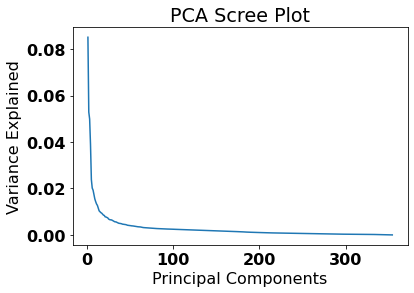

In [54]:
plot_scree()

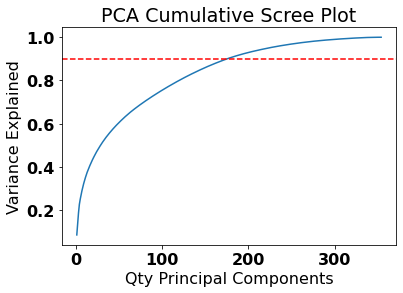

In [55]:
plot_cum_scree()

In [56]:
cum_sum_var = np.cumsum(pca.explained_variance_ratio_)
len(cum_sum_var[cum_sum_var<.9])

175

175 components can explain 90% of the variance in the AZDIAS dataframe

In [57]:
print(pca.explained_variance_ratio_[:3])
print(sum(pca.explained_variance_ratio_[:3]))

[0.08510528 0.05287741 0.04987977]
0.18786246333651835


The top 3 principal components explain 8.5%, 5.3%, and 5.0% of the variance of the AZDIAS dataset, respectively, accounting for 18.9% of the variance in the dataset.

In [58]:
#Determine component weights for Principal Component 1
component_weights(azdias_merged, 1)

,weight
MOBI_REGIO,0.137552
PLZ8_ANTG1,0.130604
KBA13_ANTG1,0.129961
LP_STATUS_FEIN,0.128123
KBA05_ANTG1,0.127321
...,...
PLZ8_ANTG4,-0.124070
KBA13_BAUMAX,-0.124175
KBA13_ANTG4,-0.125047
KBA13_ANTG3,-0.128949


The first principal component of the AZDIAS set, which accounts for 8.5% of the variance in the data, is primarily composed of features related to moving patterns/mobility (MOBI_REGIO), quantity and size of households in a given area (PLZ8_ANTG, KBA05_ANTG), share of car owners in certain age ranges (KBA13_ANTG), and social status (LP_STATUS_FEIN).

In [59]:
#Determine component weights for Principal Component 2
component_weights(azdias_merged, 2)

,weight
ONLINE_AFFINITAET,0.151169
PRAEGENDE_JUGENDJAHRE,0.146737
D19_GESAMT_ANZ_24,0.138898
CJT_TYP_1,0.135904
FINANZ_SPARER,0.135900
...,...
D19_VERSAND_ONLINE_DATUM,-0.129493
CJT_TYP_4,-0.130366
FINANZ_VORSORGER,-0.131814
CJT_TYP_5,-0.131859


The second principal component of the AZDIAS set, which accounts for 5.3% of the variance in the data, is primarily composed of features related to online affinity (ONLINE_AFFINITAET), dominating movement in person's youth (PRAEGENDE_JUGENDJAHRE), and recent transaction activity (D19_GESAMT_ANZ_24).

In [60]:
#Determine component weights for Principal Component 3
component_weights(azdias_merged, 3)

,weight
KBA13_HERST_BMW_BENZ,0.176029
KBA13_SEG_OBEREMITTELKLASSE,0.152426
KBA13_MERCEDES,0.150016
KBA13_BMW,0.147408
KBA13_SITZE_4,0.141501
...,...
KBA13_HALTER_20,-0.111616
KBA13_HALTER_25,-0.114189
KBA13_KMH_140_210,-0.124028
KBA13_SEG_KLEINWAGEN,-0.125586


The third principal component of the AZDIAS set, which accounts for 5.0% of the variance in the data, is primarily composed of features related to share of BMW and Mercedes Benz ownership (KBA13_HERST_BMW_BENZ, KBA13_MERCEDES, KBA13_BMW, KBA13_SEG_OBEREMITTELKLASSE). 

In [61]:
customers_scaled, customers_principal_comps = scale_and_pca(customers_merged)

As mentioned above, 175 components can explain 90% of the variance in the data. Therefore, we will reduce AZDIAS and customers to 175 components for further analysis.

In [62]:
def reduce_df_pca(df, n=175):
    pca = PCA(n_components = n)
    df_pca = pca.fit_transform(df)
    df_pca = pd.DataFrame(df_pca)
    return df_pca

In [63]:
azdias_pca = reduce_df_pca(azdias_scaled)

In [64]:
customers_pca = reduce_df_pca(customers_scaled)

**k-Means Clustering**
In this section k-Means clustering will be performed to segment the population. An elbow plot will be used to determine the quantity of clusters that will be most useful. Then, those clusters will be used to identify which subsets of the general population are more likely to respond yes from market targetting.

In [65]:
def get_kmeans_distances(df, n_clusters, s):
    '''
    Get k-means distances for further analysis
    INPUT
    df: dataframe to be passed for analysis
    n_clusters: number of clusters
    s: sample size of data
    '''
    #set up k-means model
    kmeans_model = KMeans(init = 'k-means++',
                          n_clusters=n_clusters,
                          max_iter=100,
                          random_state=42)
    #fit model to data
    kmeans_model = kmeans_model.fit(df.sample(s))
    #calculate kmeans_distances
    kmeans_distances = abs(kmeans_model.score(df))
    return kmeans_distances

def plot_elbow(df, range_start, range_end, s = 20000):
    '''
    Set up elbow plot for range of cluster sizes
    INPUT
    df: dataframe to be passed for analysis
    range_start: start of range for clusters
    range_end: end of range for clusters
    OUTPUT
    k-means Elbow Method Plot
    '''
    distances = []
    for n in range(range_start,range_end):
        distances.append(get_kmeans_distances(df, n, s))
    clusters = range(range_start,range_end)
    plt.plot(clusters, distances, 'bx-')
    plt.xlabel('Clusters Qty')
    plt.ylabel('Distance to Centroid')
    plt.xticks(list(range(2,20,2)))
    plt.title('k-means Elbow Method Plot')

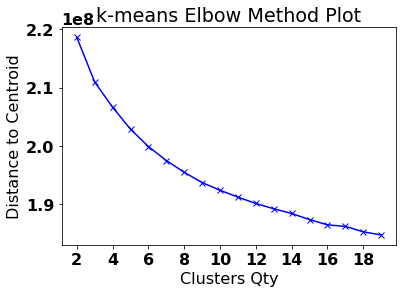

In [66]:
plot_elbow(azdias_pca,2,20)

While there is no clear elbow on the plot, it does become slightly more linear after 10 clusters. Therefore, we will use 10 clusters going forward.

In [67]:
def kmeans_predict(df, n_clusters=10):
    kmeans_model = KMeans(init = 'k-means++',
                          n_clusters=n_clusters,
                          max_iter=100,
                          random_state=42)
    kmeans_model.fit(df)
    y_kmeans = kmeans_model.predict(df)
    y_kmeans = pd.DataFrame(y_kmeans, columns = ['Cluster'])
    return y_kmeans

In [68]:
azdias_clusters = kmeans_predict(azdias_pca)
customers_clusters = kmeans_predict(customers_pca)

In [69]:
#get cluster counts for azdias and customers
azdias_cluster_counts = azdias_clusters.value_counts().sort_index()
customers_cluster_counts = customers_clusters.value_counts().sort_index()

#construct clusters dataframe with counts
clusters_df = pd.concat([azdias_cluster_counts, customers_cluster_counts], axis=1).reset_index()
clusters_df.columns = ['cluster', 'azdias_counts', 'customers_counts']

#calculate share percents for each population and cluster and add to dataframe
clusters_df['azdias_share'] = clusters_df['azdias_counts']/azdias_pca.shape[0]
clusters_df['customers_share'] = clusters_df['customers_counts']/customers_pca.shape[0]

#show dataframe
clusters_df

,cluster,azdias_counts,customers_counts,azdias_share,customers_share
0,0,74842,13051,0.101510,0.092979
1,1,60092,13061,0.081504,0.093050
2,2,105595,23038,0.143221,0.164129
3,3,50107,9729,0.067961,0.069312
4,4,91643,19776,0.124297,0.140890
5,5,97993,9339,0.132910,0.066534
6,6,49044,20053,0.066519,0.142863
7,7,64812,14232,0.087906,0.101393
8,8,45193,6796,0.061296,0.048417
9,9,97967,11290,0.132875,0.080433


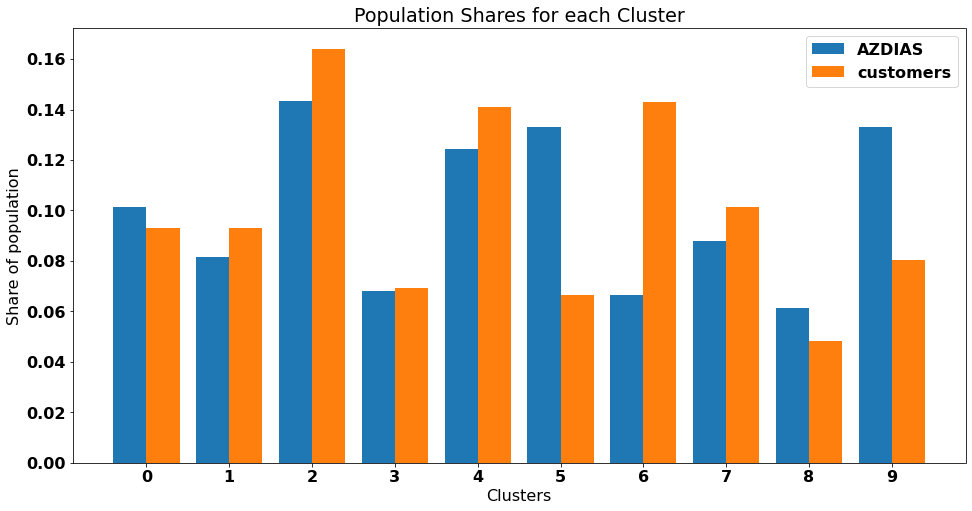

In [70]:
plt.figure(figsize = (16,8))
plt.bar(clusters_df['cluster'] - 0.2, clusters_df['azdias_share'], 0.4, label = 'AZDIAS')
plt.bar(clusters_df['cluster'] + 0.2, clusters_df['customers_share'], 0.4, label = 'customers')

plt.xticks(np.arange(len(clusters_df['cluster'])),clusters_df['cluster'])
plt.xlabel("Clusters")
plt.ylabel("Share of population")
plt.title("Population Shares for each Cluster")
plt.legend()
plt.show()

Cluster 6 reflects a substantial increase in shares for the customer base data set and overrepresented when compared to AZDIAS (general population). Clusters 2, 4, and 6 represent nearly 50% of the customers population. Targetting members of the general population in these clusters could lead to better success. More specifically, targetting those in clusters 6 should be the primary focus of a marketing campaign. Clusters 5, 8, and 9 represent populations that may want to be avoided. 

In [71]:
azdias_clusters

,Cluster
0,2
1,2
2,5
3,1
4,5
...,...
737283,1
737284,0
737285,2
737286,0


In [72]:
azdias_merged['clusters'] = azdias_clusters
customers_merged['clusters'] = customers_clusters

In [74]:
clusters_of_interest = [6, 5]
feature_comparison = pd.DataFrame()
for cluster in clusters_of_interest:
    feature_comparison[cluster] = azdias_merged[azdias_merged['clusters']==cluster].mean()

In [75]:
feature_comparison['6/5 compare'] = abs((feature_comparison[5] - feature_comparison[6])/feature_comparison[5])

In [76]:
feature_comparison.drop('clusters').sort_values('6/5 compare', ascending=False).head(10)

,6,5,6/5 compare
SOHO_KZ,0.007421,0.008480,0.124881
ANZ_TITEL,0.003747,0.004160,0.099162
D19_BANKEN_LOKAL,0.109462,0.115540,0.052608
ANZ_HH_TITEL,0.040185,0.038431,0.045653
D19_ENERGIE,0.391228,0.374829,0.043751
D19_DIGIT_SERV,0.213895,0.207082,0.032901
D19_RATGEBER,0.540037,0.557321,0.031012
D19_VERSI_ONLINE_QUOTE_12,0.025256,0.026061,0.030917
KBA05_ANTG4,0.281298,0.289577,0.028591
D19_BANKEN_ANZ_12,0.134485,0.130826,0.027973


Judging by the features that have the highest average differences between the interested and non-interested clusters, interested clusters seem to have more transactional activity for banks, energy, guidebooks, and digital services and tend to have fewer academic titles within the household.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [77]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/var/folders/dz/71j5m95x01d2wwbm3pz62vz80000gn/T/ipykernel_64359/3492614913.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')


In [78]:
describe_dataframe(mailout_train)
mailout_train.head()

The selected dataframe has 42962 rows and 367 columns.
Columns with >50% values missing:  5


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [79]:
mailout_train['RESPONSE'].value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

The mailout_train dataset has a significant imbalanced classes issues. Therefore, resampling will be required.

In [80]:
def resample_and_concat(df):
    no_response = mailout_train[mailout_train['RESPONSE']==0]
    yes_response = mailout_train[mailout_train['RESPONSE']==1]
    yes_balanced = resample(yes_response, replace=True, n_samples=42430)
    mailout_train_balanced = pd.concat([no_response, yes_balanced])
    return mailout_train_balanced

In [81]:
mailout_train_balanced = resample_and_concat(mailout_train)

In [82]:
mailout_train_balanced['RESPONSE'].value_counts()

0    42430
1    42430
Name: RESPONSE, dtype: int64

In [83]:
mailout_train_balanced = mailout_train_balanced.reset_index().drop('index',axis=1)

Now we have a balanced training set!

In [84]:
y = mailout_train_balanced['RESPONSE']
mailout_ml = mailout_train_balanced.drop('RESPONSE', axis=1)

**Data Preparation**

In [85]:
def clean_mailout(df, is_test = 'no'):
    #Replace X and XX with nan in CAMEO features and convert all to floats
    mailout_clean = fix_cameo(df,'CAMEO_INTL_2015')
    mailout_clean = fix_cameo(mailout_clean,'CAMEO_DEUG_2015')

    #Perform cleaning function on customers dataframe
    mailout_clean = clean_dataframe(mailout_clean)

    #Perform row reduction based on rows with greater than the threshold of nans in the data
    if is_test == 'no':
        mailout_clean_rows = clean_nan_rows(mailout_clean)
    else:
        mailout_clean_rows = mailout_clean

    #Fill nans for binary and non-binary features in the customers dataset
    #with mode and median, respectively
    mailout_binary, mailout_nonbinary = fill_numeric_nans(mailout_clean_rows)

    #Merge binary and nonbinary dataframes for final customers dataframe
    mailout_merged = pd.merge(mailout_nonbinary, mailout_binary ,left_index=True,right_index=True)

    #Drop ID from customers merged since it will not be used during machine learning
    mailout_train_merged = mailout_merged.drop('LNR', axis=1)
    
    return mailout_train_merged

In [86]:
mailout_train_merged = clean_mailout(mailout_ml)

In [94]:
#Reduce y to match index from mailout_train_merged
y = y[y.index.isin(mailout_train_merged.index)]

#Scale Mailout trained
mailout_train_scaled = pd.DataFrame(scaler.fit_transform(mailout_train_merged))

#Apply PCA with properties as described in the previous section
mailout_train_pca = reduce_df_pca(mailout_train_scaled)

#Set X_train to mailout_train_pca
X_train = mailout_train_scaled

In [95]:
X_train.shape

(68302, 356)

In [99]:
pipeline_models = {
    'LogisticRegression' : LogisticRegression(max_iter = 1000, random_state=42),
    'AdaBoostClassifier' : AdaBoostClassifier(random_state=42),
    'RandomForestClassifier' : RandomForestClassifier(random_state=42),
    'GradientBoostingClassifier' : GradientBoostingClassifier(random_state=42)
}

for key in pipeline_models.keys():
    cv = GridSearchCV(estimator = pipeline_models[key], param_grid={}, scoring = 'roc_auc');
    cv.fit(X_train,y);
    
    auc_score = cv.best_score_;
    print('Classifier: ', key)
    print('AUC Score: ', auc_score)
    print('---------')

Classifier:  LogisticRegression
AUC Score:  0.8413843484482308
---------
Classifier:  AdaBoostClassifier
AUC Score:  0.8625971017603391
---------
Classifier:  RandomForestClassifier
AUC Score:  1.0
---------
Classifier:  GradientBoostingClassifier
AUC Score:  0.9494100423567142
---------


While the Random Forest Classifier had the best AUC score, the perfect 1.0 should lead us to believe that it is overfitting the data, which is certainly possible with this type of data set. The other three classifiers performed well on the training data, but the Gradient Boosting Classifier seemed to perform the best at an AUC score of 0.949. We will go with that for our final model and fine-tune the parameters. 

**Gradient Boosting and Parameter Fine-tuning**

Now that we have found the best performing classifier, we need to fine-tune parameters. Based on external research, tuning number of estimators, max depth, and learning rate seem to have positive impacts on refining the classifier succesfully. Thus, those are the parameters we will toon below.

In [100]:
#Set parameters for finetuning to be used in Gridsearch with GBC
parameters = {'n_estimators': [5, 50, 100], 'max_depth': [1, 3], 'learning_rate': [0.1]}

#Set up gridsearch for GBC with the new parameters
cv = GridSearchCV(estimator = GradientBoostingClassifier(), 
                        param_grid=parameters, scoring = 'roc_auc', verbose=50)

#Fit the X_train data with response
cv.fit(X_train, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START learning_rate=0.1, max_depth=1, n_estimators=5..............
[CV 1/5; 1/6] END learning_rate=0.1, max_depth=1, n_estimators=5;, score=0.776 total time=   1.4s
[CV 2/5; 1/6] START learning_rate=0.1, max_depth=1, n_estimators=5..............
[CV 2/5; 1/6] END learning_rate=0.1, max_depth=1, n_estimators=5;, score=0.765 total time=   1.2s
[CV 3/5; 1/6] START learning_rate=0.1, max_depth=1, n_estimators=5..............
[CV 3/5; 1/6] END learning_rate=0.1, max_depth=1, n_estimators=5;, score=0.770 total time=   1.2s
[CV 4/5; 1/6] START learning_rate=0.1, max_depth=1, n_estimators=5..............
[CV 4/5; 1/6] END learning_rate=0.1, max_depth=1, n_estimators=5;, score=0.768 total time=   1.2s
[CV 5/5; 1/6] START learning_rate=0.1, max_depth=1, n_estimators=5..............
[CV 5/5; 1/6] END learning_rate=0.1, max_depth=1, n_estimators=5;, score=0.766 total time=   1.2s
[CV 1/5; 2/6] START learning_rate=0.1, max_de

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1], 'max_depth': [1, 3],
                         'n_estimators': [5, 50, 100]},
             scoring='roc_auc', verbose=50)

It looks like the best performing model had the following parameters:
- n_estimators: 100
- max_depth: 3
- learning_rate: 0.1

Therefore, we will use those parameters as we implement the final model below.

In [101]:
#Set parameters for finetuning to be used in Gridsearch with GBC
parameters = {'n_estimators': [100], 'max_depth': [3], 'learning_rate': [0.1]}

#Set up gridsearch for GBC with the new parameters
cv = GridSearchCV(estimator = GradientBoostingClassifier(), 
                        param_grid=parameters, scoring = 'roc_auc', verbose=50)

#Fit the X_train data with response
cv.fit(X_train, y)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START learning_rate=0.1, max_depth=3, n_estimators=100............
[CV 1/5; 1/1] END learning_rate=0.1, max_depth=3, n_estimators=100;, score=0.949 total time= 1.1min
[CV 2/5; 1/1] START learning_rate=0.1, max_depth=3, n_estimators=100............
[CV 2/5; 1/1] END learning_rate=0.1, max_depth=3, n_estimators=100;, score=0.946 total time= 1.1min
[CV 3/5; 1/1] START learning_rate=0.1, max_depth=3, n_estimators=100............
[CV 3/5; 1/1] END learning_rate=0.1, max_depth=3, n_estimators=100;, score=0.953 total time= 1.1min
[CV 4/5; 1/1] START learning_rate=0.1, max_depth=3, n_estimators=100............
[CV 4/5; 1/1] END learning_rate=0.1, max_depth=3, n_estimators=100;, score=0.950 total time= 1.1min
[CV 5/5; 1/1] START learning_rate=0.1, max_depth=3, n_estimators=100............
[CV 5/5; 1/1] END learning_rate=0.1, max_depth=3, n_estimators=100;, score=0.949 total time= 1.1min


GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1], 'max_depth': [3],
                         'n_estimators': [100]},
             scoring='roc_auc', verbose=50)

**Predict the test data with the chosen ML Model**

Now that we have determined the best ML model and tuned the parameters for best performance, we can apply it to the test data to predict responses.

In [102]:
#load test data
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')

/var/folders/dz/71j5m95x01d2wwbm3pz62vz80000gn/T/ipykernel_64359/3824689627.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')


In [103]:
mailout_test.shape

(42833, 366)

In [104]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


First we need to apply cleaning functions, scaling, and PCA as done previously with other datasets.

In [105]:
#apply mailout cleaning function
mailout_test_merged = clean_mailout(mailout_test, is_test='yes')

#scale mailout test data
mailout_test_scaled = pd.DataFrame(scaler.fit_transform(mailout_test_merged))

#apply PCA
mailout_train_pca = reduce_df_pca(mailout_test_scaled)

#assign scaled, cleaned, PCA data to X_test
X_test = mailout_test_scaled

In [106]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,346,347,348,349,350,351,352,353,354,355
0,6.485524e-01,-0.326023,-1.538376,-0.962638,-3.530628e-01,-0.149514,-0.247607,-1.887359e-02,-0.340189,-1.056549e-01,...,0.125003,1.600254,-0.339041,2.923722,-0.430497,0.495122,-0.088114,-0.252176,-0.811811,-1.213276
1,-4.132376e-16,-0.326023,0.000000,-2.473613,9.848634e-01,-0.149514,-0.247607,-8.226559e-01,1.151929,-1.056549e-01,...,0.125003,-0.624901,-0.339041,-0.342030,-0.430497,0.495122,-0.088114,-0.252176,-0.811811,-1.213276
2,6.485524e-01,4.700435,1.009894,0.296508,-3.530628e-01,-0.149514,-0.247607,1.588691e+00,-0.340189,-1.056549e-01,...,0.125003,1.600254,2.949492,-0.342030,2.322897,0.495122,-0.088114,3.965490,-0.811811,0.824215
3,-4.132376e-16,3.443821,0.000000,-2.473613,-4.273920e-01,-0.149514,-0.247607,-1.626438e+00,-0.418721,-1.056549e-01,...,0.125003,-0.624901,-0.339041,-0.342030,-0.430497,-2.019706,-0.088114,-0.252176,1.231815,0.824215
4,-1.212504e+00,-0.326023,2.425600,0.800166,-4.273920e-01,-0.149514,-0.247607,1.588691e+00,-0.418721,-1.056549e-01,...,0.125003,-0.624901,2.949492,2.923722,-0.430497,0.495122,-0.088114,-0.252176,-0.811811,0.824215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42828,-4.132376e-16,0.000000,0.000000,0.000000,6.601762e-17,0.000000,0.000000,3.569510e-16,0.000000,-1.676307e-17,...,0.125003,-0.624901,-0.339041,-0.342030,-0.430497,0.495122,-0.088114,-0.252176,-0.811811,0.824215
42829,-3.073561e+00,-0.326023,-0.688952,0.044679,-3.530628e-01,-0.149514,-0.247607,-8.226559e-01,-0.340189,-1.056549e-01,...,0.125003,-0.624901,-0.339041,2.923722,-0.430497,0.495122,-0.088114,-0.252176,-0.811811,-1.213276
42830,-4.132376e-16,-0.326023,1.009894,1.303824,-4.273920e-01,-0.149514,5.209162,7.849087e-01,-0.418721,-1.056549e-01,...,0.125003,1.600254,-0.339041,-0.342030,-0.430497,0.495122,11.348875,-0.252176,1.231815,-1.213276
42831,-4.132376e-16,-0.326023,0.000000,-2.473613,-4.273920e-01,-0.149514,-0.247607,-8.226559e-01,-0.418721,-1.056549e-01,...,0.125003,1.600254,-0.339041,-0.342030,-0.430497,0.495122,-0.088114,-0.252176,-0.811811,0.824215


Now that we have a cleaned test set, we can apply the model to make predictions!

In [107]:
#make predictions on X_test
y_pred = cv.best_estimator_.predict_proba(X_test)

In [108]:
y_pred.shape

(42833, 2)

In [109]:
#set up dataframe with LNR (ID) and prediction percent (likelihood of responding with a yes)
predictions = pd.DataFrame({'LNR': mailout_test['LNR'], 'predict_pcnt': y_pred[:,1]})
predictions

,LNR,predict_pcnt
0,1754,0.672642
1,1770,0.623442
2,1465,0.057614
3,1470,0.353410
4,1478,0.210004
...,...,...
42828,67615,0.142287
42829,67938,0.198839
42830,67942,0.178351
42831,67949,0.749311


In [111]:
sum(predictions['predict_pcnt']>=.5)/mailout_test.shape[0]

0.10176732892862979

It appears that 10.1% of the mailout test set was predicted to have more than a 50% chance of responding positively. Therefore, this is the population that should be targeted by the marketing campaign.

# Conclusion

In this project, we were provided customers and population data from a marketing firm to analyze with the goal of understanding what customer segments for the marketing firm to target and predict what customers would have a positive response. We cleaned the data using a variety of cleaning techniques to standardize the data, account for nans, and scale the data. We used PCA and k-means as unsupervised learning models to identify principal components and segment the population. Finally, we used GridSearch to identify the best machine learning model to use for predictions. The Gradient Boosting Classifier gave us the best results, so we applied it to the test data and identified 10.1% of the population that would be most likely to respond from a marketing campaign.

**Sources**
Special thanks to the following sources that contributed to shaping a great deal of my analysis. In addition to the sources below, special thanks to the stackoverflow community for all of their support. Lastly, thank you to Udacity for setting up the framework for this Capstone Project and all of their useful content!

- PCA using Python (scikit-learn) https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
- How to Create a Scree Plot in Python (Step-by-Step): https://www.statology.org/scree-plot-python/
- Customer Segmentation with Machine Learning https://towardsdatascience.com/customer-segmentation-with-machine-learning-a0ac8c3d4d84
- Elbow Method for Optimal Value of k in kmeans https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
- The Most Comprehensive Guide to K-Means Clustering you'll Ever Need https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/
- Gradient Boosting Hyperparameters Tuning: Classifier Example: https://www.datasciencelearner.com/gradient-boosting-hyperparameters-tuning/